# 反馈系统的稳定性

In [1]:
%matplotlib inline
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib
import holoviews as hv

hv.notebook_extension()

C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


$$G(s) = \frac{P(s) \cdot C(s)}{1 + P(s) \cdot C(s)}$$

$$P(s) \cdot C(s) = \frac{b(s)}{a(s)}$$

$$G(s) = \frac{b(s)}{a(s) + b(s)}$$

In [2]:
class System:
    def __init__(self, b, a):
        self.b = np.poly1d(b, variable="s")
        self.a = np.poly1d(a, variable="s")
        
    def __mul__(self, other):
        if isinstance(other, System):
            return System(self.b * other.b, self.a * other.a)
        else:
            return System(self.b * other, self.a)
        
    def feedback(self):
        return System(self.b, self.a + self.b)
    
    def poles(self):
        return np.roots(self.a)
    
    def step(self, t):
        return signal.step((self.b, self.a), T=t)[1]
    
    def __str__(self):
        b = str(self.b).split("\n")
        a = str(self.a).split("\n")
        width_b = max(len(line) for line in b)
        width_a = max(len(line) for line in a)        
        b = [line.ljust(width_b) for line in b]
        a = [line.ljust(width_a) for line in a]
        width = max(width_a, width_b)
        return "\n".join([l.center(width) for l in b] + ["-" * width] + [l.center(width) for l in a])
    
    def __repr__(self):
        return str(self)
    
def P(*args):
    return np.poly1d(args)    

In [3]:
L = System(3 * P(1, 6)**2, P(1, 0) * P(1, 0.8)**2)
G = L.feedback()
print(L)
print()
print(G)

     2              
  3 s + 36 s + 108  
--------------------
   3       2        
1 s + 1.6 s + 0.64 s

         2                 
      3 s + 36 s + 108     
---------------------------
   3       2               
1 s + 4.6 s + 36.64 s + 108


In [4]:
from scipy import signal

C:\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


:Layout
   .HoloMap.I  :HoloMap   [k]
      :Points   [x,y]
   .HoloMap.II :HoloMap   [k]
      :Curve   [x]   (y)
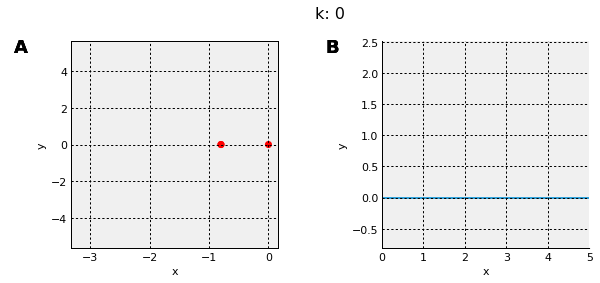
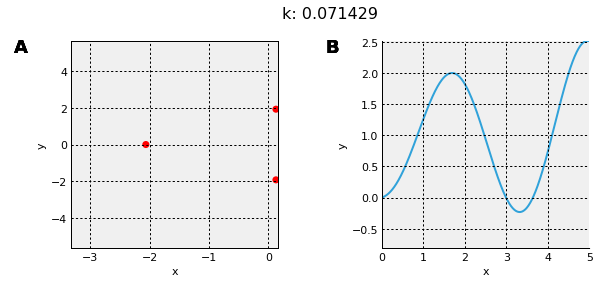
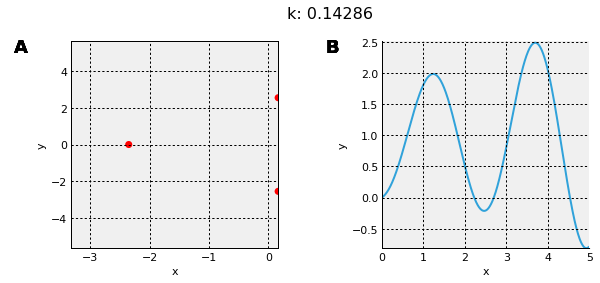
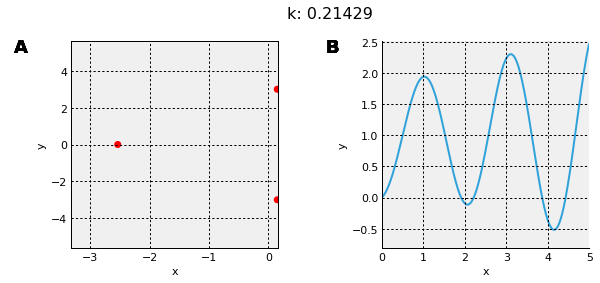
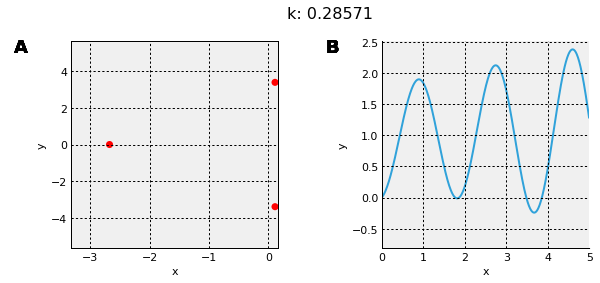
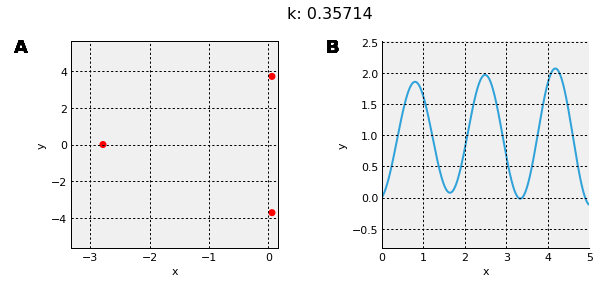
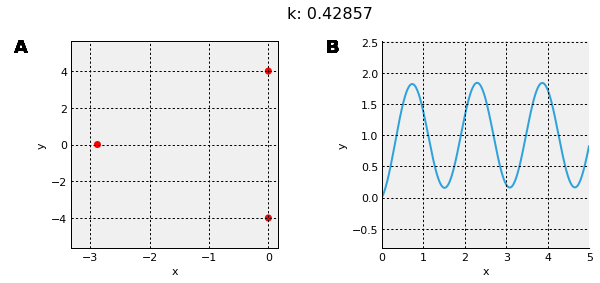
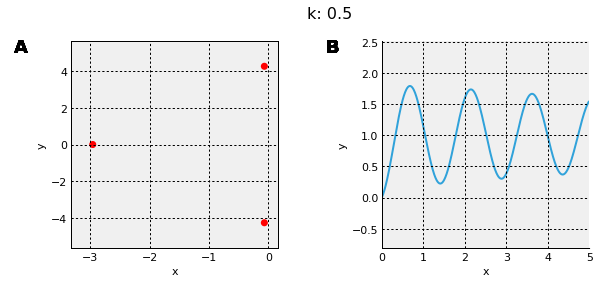
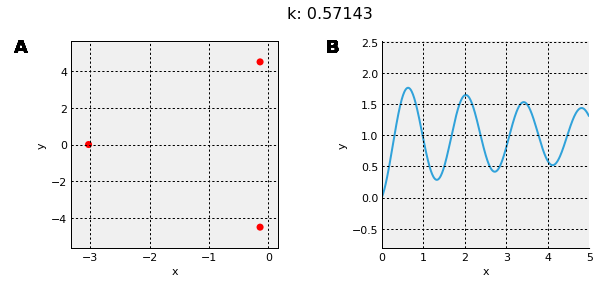
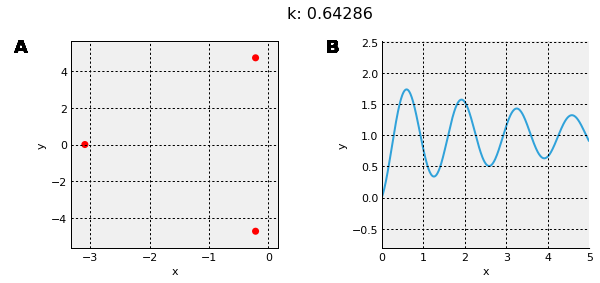
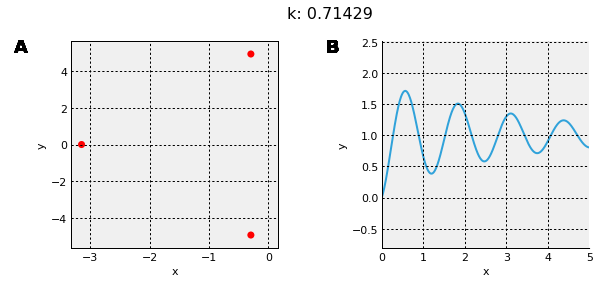
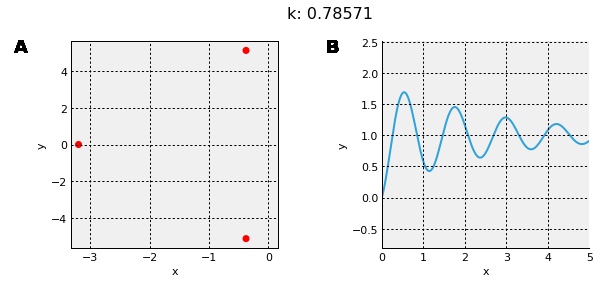
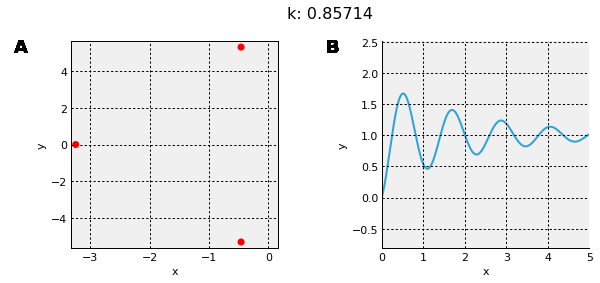
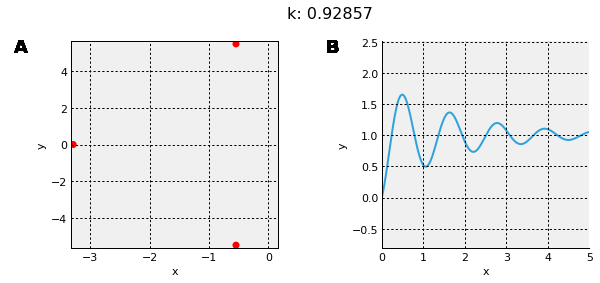
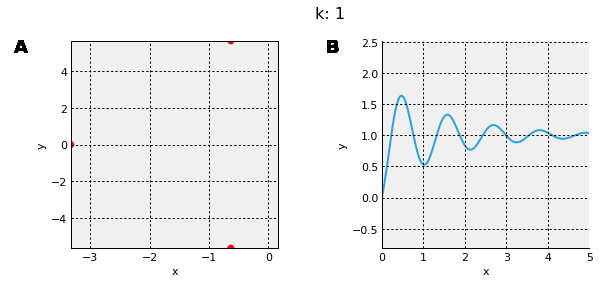

In [5]:
%opts Points (s=50, color="red")
hm_poles = hv.HoloMap(kdims=["k"])
hm_step = hv.HoloMap(kdims=["k"])

t = np.arange(0, 5, 0.01)

for k in np.linspace(0, 1, 15):
    sys = (L * k).feedback()
    poles = sys.poles()
    hm_poles[k] = hv.Points(np.c_[poles.real, poles.imag])
    hm_step[k] = hv.Curve(np.c_[t, sys.step(t)])
    
hm_poles + hm_step

## 奈奎斯特围道

奈奎斯特围道是包括剔除原点的整个右半平面的路径。可以用下面的图近似表示：

* $-j \omega_2 \rightarrow - j \omega_1$为Y轴小于0的部分
* $-j \omega_1 \rightarrow j \omega_1$的半圆是剔除原点的部分
* $j \omega_1 \rightarrow j \omega_2$是Y轴大于0的部分
* $j \omega_2 \rightarrow - j \omega_2$的半圆是包含右半平面的部分

其中$\omega_2 \rightarrow \infty$，$\omega_1 \rightarrow 0$。

In [8]:
from matplotlibhelp import add_arrows

In [9]:
def make_ny(r1, r2, n_line=100, n_circle=100):
    r1log = np.log10(r1)
    r2log = np.log10(r2)
    return np.r_[
        -1j * np.logspace(r2log, r1log, n_line),
        r1 * np.exp(np.linspace(-np.pi/2, np.pi/2, n_circle) * 1j),
        1j * np.logspace(r1log, r2log, n_line),
        r2 * np.exp(np.linspace(np.pi/2, -np.pi/2, n_circle) * 1j),
    ]
    
path = make_ny(1, 40)
fig, ax = pl.subplots()
line, = ax.plot(path.real, path.imag)
add_arrows(line, 4)
ax.set_aspect("equal");

将奈奎斯特围道通过开环传递函数映射之后的路径被成为奈奎斯特路径。闭环传递函数的稳定性可以由奈奎斯特路径顺时针围绕点$(-1, 0)$的圈数决定。在下面的图中，`k`为0.1时圈数为1，表示闭环系统不稳定。而`k`为1时圈数为0，闭环系统稳定。

b':HoloMap   [k]\n   :Overlay\n      .Curve.I  :Curve   [x]   (y)\n      .Points.I :Points   [x,y]'
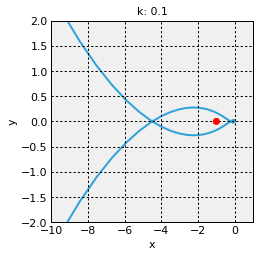
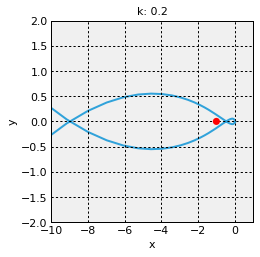
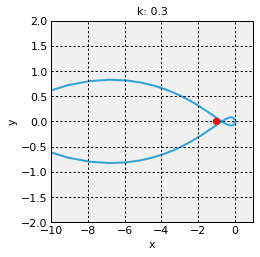
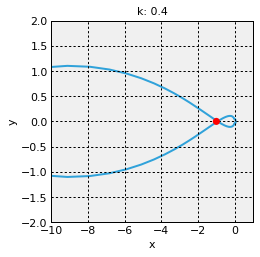
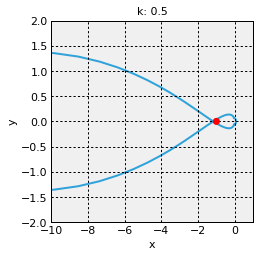
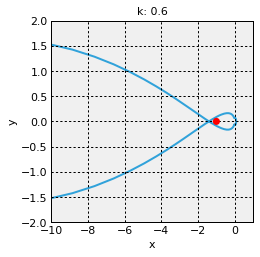
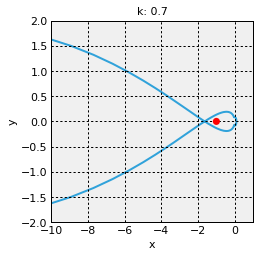
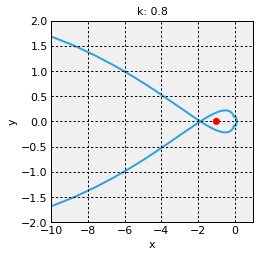
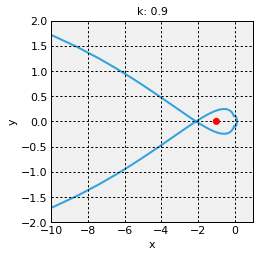
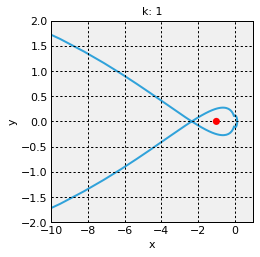

In [10]:
hm_ny = hv.HoloMap(kdims=["k"])
path = make_ny(0.1, 30)
for k in np.linspace(0.1, 1, 10):
    sys = L * k
    ny_path = np.polyval(sys.b, path) / np.polyval(sys.a, path)
    curve = hv.Curve(np.c_[ny_path.real, ny_path.imag])
    curve2 = curve.redim(
        x=hv.Dimension("x", range=(-10, 1)), 
        y=hv.Dimension("y", range=(-2, 2))) * hv.Points([[-1, 0]])
    hm_ny[k] = curve2
    
hm_ny

下面显示`k`为1时的完整奈奎斯特曲线以及其在$(-1, 0)$处的放大图。由图可以看出曲线顺时针方向和逆时针方向各绕$(-1, 0)$一次，因此相互抵消。

In [11]:
def final(curve_plot, curve):
    ymin, ymax = curve.vdims[0].range
    xmin, xmax = curve.kdims[0].range
    axis = curve_plot.handles["axis"]
    if xmin is not None:
        axis.set_xlim(xmin, xmax)
    if ymin is not None:
        axis.set_ylim(ymin, ymax)
    add_arrows(curve_plot.handles["artist"], 7)

:Layout
   .Overlay.I  :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Points.I :Points   [x,y]
   .Overlay.II :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Points.I :Points   [x,y]
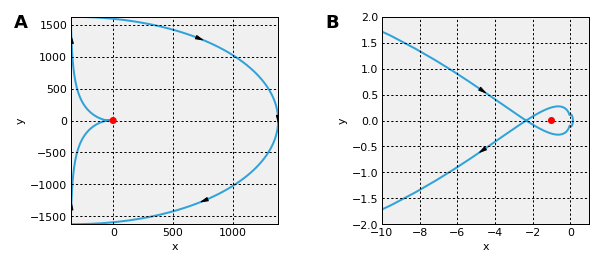

In [12]:
%%opts Curve [final_hooks=[final]] {+axiswise}
hm_ny[1].redim(x=hv.Dimension("x"), y=hv.Dimension("y")) + hm_ny[1]